In [5]:
import pandas 
import pylab
from pandas import *
from pylab import *
import os

In [6]:
import pandas 

def readFileFlink(filename):
    return read_csv(filename,names = ["nan4","nan","passengerCnt", "num ele",
                                               "Latency","Time","nan2","nan3"])  
    
def readFileSpark(filename):
    return read_csv(filename,names = ["nan4","nan","passengerCnt", "num ele",
                                      "Latency","Time","nan2","nan3"])  

def getMeanLatency(file):
    lat=file.ix[1:len(file)-2,[4]]
    m=lat.mean()[0]
    return round(m,1)
def getSumElements(file):
    nums=file.ix[1:len(file)-2,[3]]
    return nums.sum()[0]
def getBatch(name):
    out=""
    for l in name:
        if(l=="-"):
            b=False
            return int(out)
        if(l=="c"):
            return 1000
        out+=str(l)
    return int(out)

def getTupleSpark(file,path):
    parts=path.split("\\")
    return (parts[1],int(parts[2]),int(parts[3]),int(parts[4]),int(getMeanLatency(file)),getSumElements(file),getBatch(parts[5]))
def getTupleFlink(file,path):
    parts=path.split("\\")
    return (parts[1],int(parts[2]),int(parts[3]),int(parts[4]),int(getMeanLatency(file)),getSumElements(file),0)
def mergeDuplicates(num,df):
    sys="system"
    win="windowSize"
    sli="slidingSize"
    wor="workload"
    lat="latency"
    ele="num elements"
    bat="batchtime"
    end=0
    found=False
    #print(df.iloc[0][sys])
    if(num==len(df)-2):
        return df
    for i in range (num,len(df)-1):
        
        if( (df.iloc[i][sys]==df.iloc[i+1][sys]) and (df.iloc[i][win]==df.iloc[i+1][win]) ):
            if( (df.iloc[i][sli]==df.iloc[i+1][sli]) and (df.iloc[i][wor]==df.iloc[i+1][wor]) ):
                if( (df.iloc[i][bat]==df.iloc[i+1][bat]) ):
                    sums=(df.iloc[i][ele]+df.iloc[i+1][ele])
                    avg= (df.iloc[i][lat]*df.iloc[i][ele]+df.iloc[i+1][lat]*df.iloc[i+1][ele])/sums
                    df.set_value(i,lat,avg)
                    end=i
                    found=True
                    #df.index[i][lat]=avg
                    #df.index[i][ele]=sums
                    break;
                    #df=df.drop(df.index[[i+1]])
                    #print(avg,sums)
                    #print("------")
        #print(df[1])
     
    
    if (found):
        return mergeDuplicates( end,df.drop(df.index[[end+1]]) )
    else:
        return df
    
    
def ignoreLowWorkload(delta,df):
    return df.loc[df.loc[:,"workload"]>=delta]
    #print(df.loc[:,"workload"]>delta)

#df=getResults()
#df=mergeDuplicates(0,df)
#ignoreLowWorkload(75000,df)
#df
#df.drop(df.index[[1,3]])
#df[0:10]
#iris.drop(iris.index[[1,3,5,7]])

In [7]:
#find all results
import glob, os
#os.chdir("/results")
def getResults():
    
    flink=True
    data=list()
    #df = DataFrame(data,columns=index)   
    index=["system","windowSize","slidingSize","workload","latency","num elements","batchtime"]



    for sysDir in glob.glob("results\*"):
        if (sysDir=="results\spark"):
            flink=False
        else:
            flink=True
        for windowTime in glob.glob(sysDir+"\*"):
            for slidingTime in glob.glob(windowTime+"\*"):
                for workload in glob.glob(slidingTime+"\*"):
                    for files in glob.glob(workload+"\*"):
                        found=False
                        if(flink):
                            if (os.path.getsize(files)>0):
                                file=readFileFlink(files)
                                t=getTupleFlink(file,files)
                                found=True
                                #print(file,"/n",files)
                        else:
                             if (os.path.getsize(files)>0):
                                file=readFileSpark(files)
                                t=getTupleSpark(file,files)
                                found=True
                        if(found):      
                            data.append(t)
    df = DataFrame(data,columns=index)                        
    df.append(Series(t[0:7],index=index),ignore_index=True) 
    return df
df=getResults()
#df
#resS=df.loc[df["system"]=="flink"].loc[df["windowSize"]==3000].loc[df["slidingSize"]==2000]
#resS
#df=mergeDuplicates(0,df)
df

,system,windowSize,slidingSize,workload,latency,num elements,batchtime
0,flink,1000,1000,100000,23,6558260,0
1,flink,1000,1000,100000,27,5673572,0
2,flink,1000,1000,100000,17,4473643,0
3,flink,1000,1000,100000,23,11001769,0
4,flink,1000,1000,100000,19,10998653,0
5,flink,1000,1000,100000,19,12946548,0
6,flink,1000,1000,100000,18,2660444,0
7,flink,1000,1000,100000,19,5249795,0
8,spark,12000,1000,100000,469,16001481,1000
9,spark,15000,1000,100000,554,28878173,1000


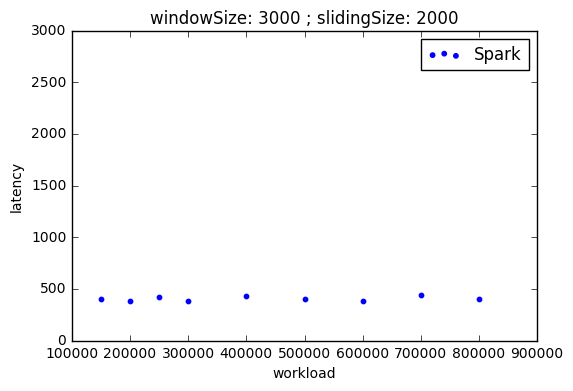

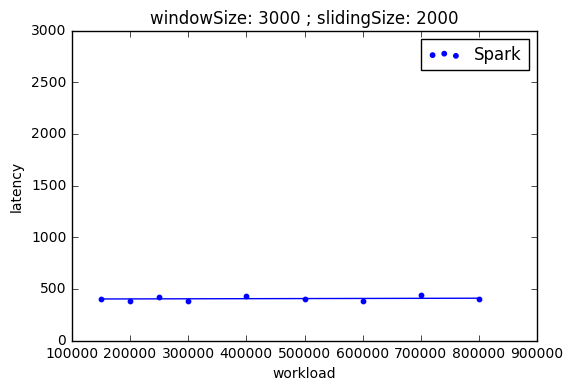

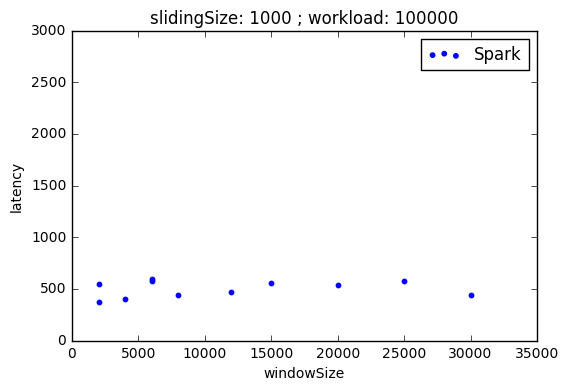

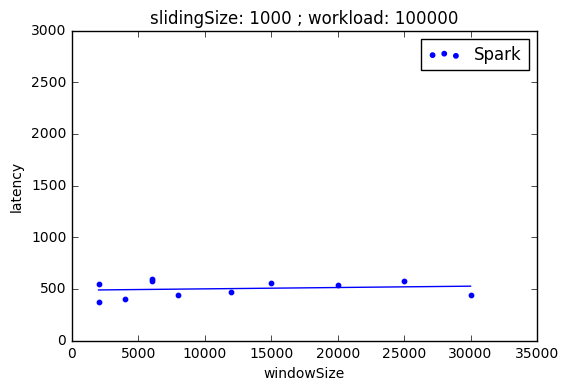

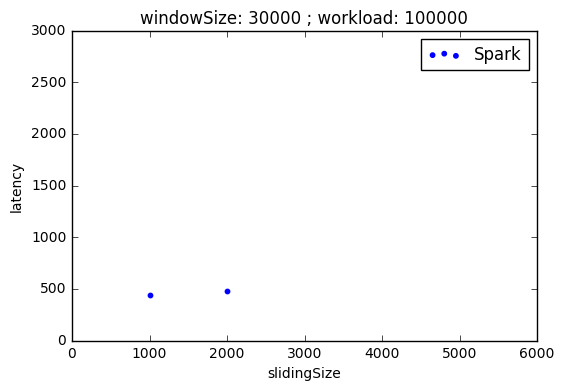

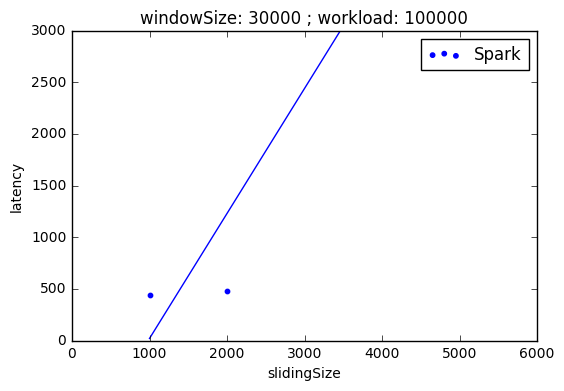

In [8]:
#analysis
#import seaborn
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def plotLatency(varName2,var2,varName3,var3,xName,yName):
    
    resS=df.loc[df["system"]=="spark"].loc[df[varName2]==var2].loc[df[varName3]==var3]
    resF=df.loc[df["system"]=="flink"].loc[df[varName2]==var2].loc[df[varName3]==var3]
    titleString=varName2+": "+str(var2)+" ; "+varName3+": "+str(var3)
    
    olsS=sm.ols(formula="latency ~ %s"%xName, data=resS).fit()
    print(olsS.params[0],olsS.params[1])
    ax=resS.plot.scatter(x=xName,y=yName,label="Spark",color="Blue")
    resF.plot.scatter(x=xName,y=yName,label="Flink",ax=ax,color="Red",title=titleString)
    path='graphs/%s%s%s%s.png' %(varName2,var2,varName3,var3)
    #savefig(path)
    
def plotLatency2(varName2,var2,varName3,var3,xName,yName,save):
    spark=True
    flink=False
     #make plot without regression line
    if(spark):
        resS=df.loc[df["system"]=="spark"].loc[df[varName2]==var2].loc[df[varName3]==var3]
        xS=resS[xName].values
        yS=resS[yName].values
        plt.scatter( xS , yS ,color="Blue",s=10,label="Spark")
    if(flink):
        resF=df.loc[df["system"]=="flink"].loc[df[varName2]==var2].loc[df[varName3]==var3]    
        xF=resF[xName].values
        yF=resF[yName].values
        plt.scatter( xF , yF ,color="Red",s=10,label="Flink")
    
    titleString=varName2+": "+str(var2)+" ; "+varName3+": "+str(var3)
    
    plt.ylim([0,3000])
    plt.title(titleString)
    plt.xlabel(xName)
    plt.ylabel(yName)
    plt.legend()
    
    path='graphs/%s%s%s%s.png' %(varName2,var2,varName3,var3)
    
    if(save):
        savefig(path)   
    plt.show()
    
    #make plot with regression line
    if(spark):
        plt.scatter( xS , yS ,color="Blue",s=10,label="Spark")
        plt.plot(np.unique(xS), np.poly1d(np.polyfit(xS, yS, 1))(np.unique(xS)),color="Blue")
    if(flink):
        plt.scatter( xF , yF ,color="Red",s=10,label="Flink")
        plt.plot(np.unique(xF), np.poly1d(np.polyfit(xF, yF, 1))(np.unique(xF)),color="Red")
    
    plt.ylim([0,3000])
    plt.title(titleString)
    plt.xlabel(xName)
    plt.ylabel(yName)
    plt.legend()
    
    path='graphs/%s%s%s%s_With.png' %(varName2,var2,varName3,var3)
    
    if(save):
        savefig(path)   
    plt.show()   
    
    
sys="system"
win="windowSize"
sli="slidingSize"
wor="workload"
lat="latency"
ele="num elements"

df=getResults()
#df=mergeDuplicates(0,df)
df=ignoreLowWorkload(50000,df)

plotLatency2(win,3000,sli,2000,wor,lat,True)

plotLatency2(sli,1000,wor,100000,win,lat,True)

plotLatency2(win,30000,wor,100000,sli,lat,True)


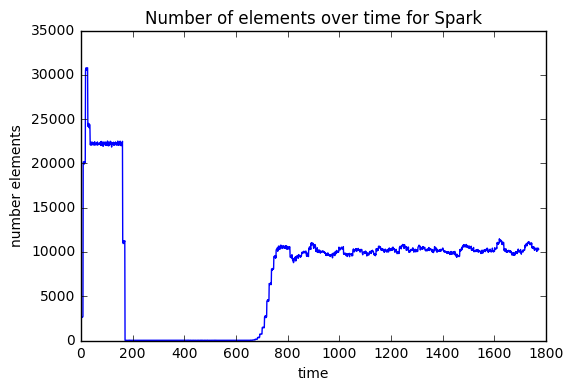

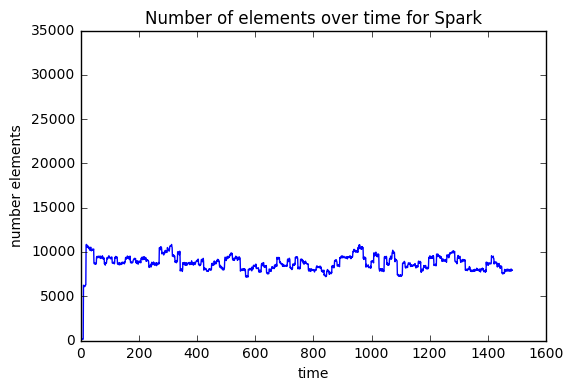

In [26]:
#show number of elements to illustrate backpressuring

import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
for file in glob.glob("result-example\*"):
    r= read_csv(file,names = ["nan4","nan","passengerCnt", "num ele","Latency","Time","nan2","nan3"])  
    y=r["num ele"].values
    x=np.arange(0,len(y))
    #plt.scatter( x , y ,color="Blue",s=1,label="Spark")
    plt.plot(x,y)
    plt.title("Number of elements over time for Spark")
    plt.xlabel("time")
    plt.ylabel("number elements")
    plt.ylim([0,35000])
    plt.show()        